# Simulation of user behaviour using knowledge tracing
Simulate a user's performance on a task and the performance of the knowledge tracing algorithm. 

To dos: 

1. put some randomness into the user's answers so they don't just agree and see what happens. 
2. figure out what's happening with the image model
3. maybe some randomness with images for the user model as well? 
4. see where we are with the parameters based on real data 

In [15]:
%matplotlib inline  
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.mlab import csv2rec
import numpy as np

## step_user_model
Takes one time step for modelling the user, given whether the user agreed with the ML answer, our current belief about whether they've learned (L), the ML confidence in the image classification (M) and the three learning probability parameters, T (learning), G (guess right even when they don't know) and S (slip, answer wrong even if they do know).

In [2]:
def step_user_model(agree, L, M, T, G, S):    
    p_correct = L * (1 - S) + (1 - L) * G
    p_agree   = M * p_correct + (1 - M) * (1 - p_correct)
    p_agree_l = M * (1 - S) + (1 - M) * S
    
    p_l_answer = p_agree_l * L / p_agree if agree else \
                 (1 - p_agree_l) * L / (1 - p_agree)
    
    return p_l_answer + (1 - p_l_answer) * T

## pick_agree
A function to simulate the user's answer given their state of knowledge and ML confidence in the image. For simplicity, we start by having the user always agree with the ML. 

In [3]:
def pick_agree(L, M):
    return True

## Example run.

In [4]:
T = 0.2
G = 0.1
S = 0.4
L = 0.3
M = 0.7

N = 0
print(N, L)
while L < 0.95:
    L = step_user_model(pick_agree(L, M), L, M, T, G, S)
    N += 1
    print(N, L)

0 0.3
1 0.524
2 0.7089208633093527
3 0.8356659897264367
4 0.9118597422225323
5 0.9541052114554386


## count_steps
A bit of scafolding to count how many steps it takes for the parameter to hit some target. Note that we stop counting at 100 (yes, some of the runs took more than that).

In [5]:
def count_steps(agree, to, step, L, M, T, G, S):
    N = 0
    while L < to and N < 100:
        L = step(agree(L, M), L, M, T, G, S)
        N += 1
    return N

An example: 3 steps for a user to move from .3 to .95 confidence of having learned to classify given images of .9 ML confidence. 

In [6]:
count_steps(agree=pick_agree, to=0.95, step=step_user_model, L=.3, M=.9, T=.3, G=.05, S=.4)

3

### Plot of performance
Trying some plots to see how the two parameters, G and S, affect the how long it takes to learn. Using numpy functions to get the input variables as a matrix. 

In [7]:
X = np.linspace(0, .45, 10)
Y = np.linspace(0, .45, 10)
X, Y = np.meshgrid(X, Y)

Then mapping count_steps across the space and collecting results as a new matrix. 

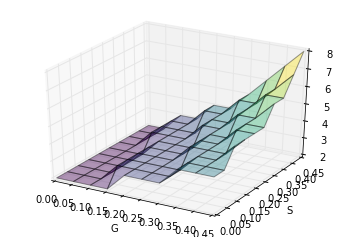

In [17]:
Z_users = np.matrix([count_steps(agree=pick_agree, to=0.95, step=step_user_model, L=.3, M=.95, T=.2, G=g, S=s) for g, s in np.nditer([X,Y])]).reshape(X.shape)
cmap=plt.get_cmap('viridis')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z_users, rstride=1, cstride=1, alpha=0.4, cmap=cmap) 
ax.set_xlabel('G')
ax.set_ylabel('S')

So, takes longer for user to learn as G increases, and some interaction with S. Hmm, I wonder if this is an artifact of the user always agreeing. Agreeing but never guessing is most likely because they are learning to do the task correctly. 

## step_image_model
Takes one time step for modelling beliefs about the image, given whether the user agreed with the ML answer. Other parameters are as above. Note that T isn't used, but is there for compatibility with count_steps. 

In [19]:
def step_image_model(agree, M, L, T, G, S):
    p_agree_m = \
    p_correct = L * (1 - S) + (1 - L) * G
    p_agree   = M * p_correct + (1 - M) * (1 - p_correct)
    
    p_m_answer = p_agree_m * M / p_agree if agree else \
                 (1 - p_agree_m) * M / (1 - p_agree)

    return p_m_answer

Example run.

In [20]:
G = 0.2
S = 0.3
M = 0.5
L = 0.95

N = 0
while M < 0.95:
    M = step_image_model(pick_agree(L, M), M, L, T, G, S)
    N += 1
    print(N, M)

1 0.6749999999999999
2 0.8118040089086859
3 0.8995886654478976
4 0.9489983964342984
5 0.9747766334696538


Example: takes 8 steps for confidence in classification to increase from 0.7 to 0.95 with given parameters. 

In [22]:
count_steps(pick_agree, 0.95, step_image_model, 0.7, 0.95, T=.3, G=.05, S=.4)

8

### Plot of performance

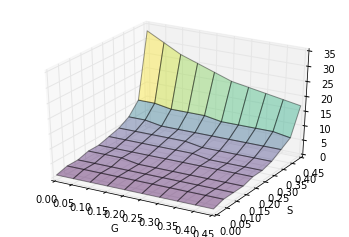

In [23]:
Z_images = np.matrix([count_steps(pick_agree, 0.95, step_image_model, .5, .95, T=.3, G=g, S=s) for g, s in np.nditer([X,Y])]).reshape(X.shape)
cmap=plt.get_cmap('viridis')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z_images, rstride=1, cstride=1, alpha=0.4, cmap=cmap)
ax.set_xlabel('G')
ax.set_ylabel('S')

This is really weird: If there's a high chance of slipping, then it takes forever for the model to learn what the image is. I guess that's because we don't really trust the user's answer if we think they might have made a mistake. But there's an interaction with guessing: it's not so bad if they also guess right a lot. The implication is maybe that we want to train people not to slip?

## More realistic model of user behaviour
A function to model a user's agreement as function of what they know and likelihood image is of class. So, agree if both human and machine are right or both are wrong 

In [9]:
def make_random_agreement(L):
    # make a function that assumes a fixed level of learning for a user
    return lambda x, M: np.random.random_sample() < (L*M + (1-L)*(1-M))

In [10]:
[make_random_agreement(.6)(.6, .9) for i in range(1,10)]

[False, True, True, True, False, True, False, False, False]

In [25]:
steps = [count_steps(agree=make_random_agreement(.7), to=0.95, step=step_user_model, L=.7, M=.9, T=.1, G=.15, S=.15) for i in range(1,50)]

In [30]:
np.std(steps)

2.7444237508594673

(array([ 17.,   9.,   6.,   6.,   4.,   2.,   2.,   1.,   0.,   2.]),
 array([  2. ,   3.1,   4.2,   5.3,   6.4,   7.5,   8.6,   9.7,  10.8,
         11.9,  13. ]),
 <a list of 10 Patch objects>)

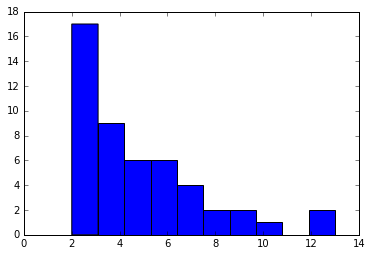

In [31]:
plt.hist(steps)